# 02. Neural Network classification with PyTorch

Classification is a problem whether something is one thing or another (there can be multiple things as the options).

| Hyperparameter      | Binary Classification | Multiclass Classification |
| --- | --- | --- |
| **Input layer shape (`in_features`)**      | Same as number of features (e.g. 2 for age, sex)  | Same as binary classification |
| **Hidden layer(s)**  | Problem specific, minimum=1, maximum=unlimited    | Same as binary classification |
| **Neurons per hidden layer**  | Problem specific, generally 10 to 512    | Same as binary classification |
| **Output layer shape (`out_features`)**  | 1 (one class or other   | 1 per class (e.g. 3 for food, person or dog person) |
| **Hidden layer activation**  | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but can be [many others](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)    | Same as binary classification |
| **Output activation**  | Sigmoid ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)   | Softmax ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#softmax) in PyTorch |
| **Loss function**  | Binary crossentropy ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch)    | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch|

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


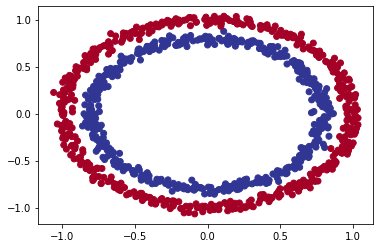

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first sample of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample}")
print(f"Values for one sample of y: {y_sample}")
X_sample.shape, y_sample.shape

Values for one sample of X: [0.75424625 0.23148074]
Values for one sample of y: 1


((2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
import torch
torch.__version__

'1.13.1+cu116'

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if available.
1. Construct the model (by subclassing `nn.Module`).
1. Define a loss function and optimizer.
1. Create a training and test loop.

In [11]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data.
3. Define a `forward()` method that outlines the forawrd pass (or forward computation).
4. Instantiate an instance of our model class and send it to the target `device`.

In [12]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of hadling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)
  
  # 3. Define a forward method
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression you might want MSE or MAE.

For classification, you might want binary crossentropy or categorical cross enrtopy.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in optimizers.

- For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`.

In [13]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
1. Calculate the loss
1. Optimizer zero grad
1. Loss backward
1. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function.

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [15]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0217],
        [ 0.0179],
        [ 0.1271],
        [-0.0086],
        [ 0.2787]])

In [16]:
# Use the sigmoid activation function on our model logits to run them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5054],
        [0.5045],
        [0.5317],
        [0.4978],
        [0.5692]])

For our prediction probability values, we need to perform a range-style rounding on them:
- `y_pred_probs` >= 0.5, `y=1` (class 1)
- `y_pred_probs` < 0.5, `y=0` (class 1)

In [17]:
# Find the predicted labels from probabilites
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


### 3.2 Creating a train and test loop

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the accuracy
  loss = loss_fn(y_logits,
                 y_train)
  
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)
    
  # Print logs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69767 | Acc: 56.38 | Test loss: 0.69448 | Test acc: 58.50
Epoch: 10 | Loss: 0.69507 | Acc: 52.00 | Test loss: 0.69321 | Test acc: 57.50
Epoch: 20 | Loss: 0.69415 | Acc: 50.62 | Test loss: 0.69301 | Test acc: 54.50
Epoch: 30 | Loss: 0.69376 | Acc: 50.25 | Test loss: 0.69307 | Test acc: 52.00
Epoch: 40 | Loss: 0.69354 | Acc: 50.38 | Test loss: 0.69317 | Test acc: 49.50
Epoch: 50 | Loss: 0.69341 | Acc: 49.50 | Test loss: 0.69328 | Test acc: 49.00
Epoch: 60 | Loss: 0.69331 | Acc: 50.12 | Test loss: 0.69338 | Test acc: 48.50
Epoch: 70 | Loss: 0.69324 | Acc: 49.38 | Test loss: 0.69347 | Test acc: 52.00
Epoch: 80 | Loss: 0.69318 | Acc: 49.25 | Test loss: 0.69356 | Test acc: 49.50
Epoch: 90 | Loss: 0.69314 | Acc: 49.88 | Test loss: 0.69365 | Test acc: 50.00


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predcitions and make them visual!

In other words, "Visualize, visualize, visalize!"

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [19]:
import requests
from pathlib import Path

# Download helper functions from PyTorch course repo
if Path("helper_functions.py").is_file():
  print("File already exists, skippind download")
else:
  print("Download helper functions")
  response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  
  with open("helper_functions.py", "wb") as f:
    f.write(response.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper functions


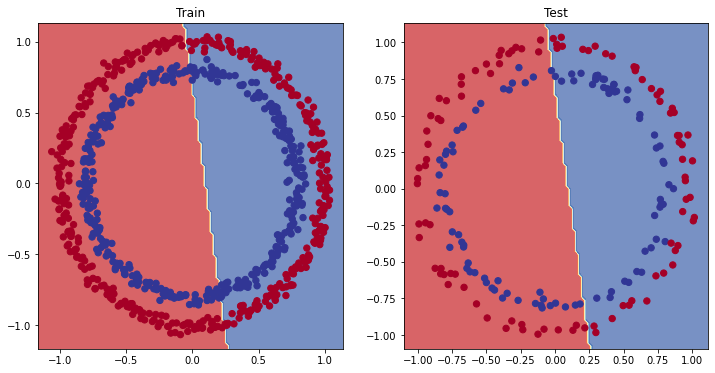

In [20]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 -> 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

In [21]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    
    return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
# Create an instance
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [23]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test loss: 0.69437 | Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test loss: 0.69458 | Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test loss: 0.69465 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69467 | Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test loss: 0.69468 | Test acc: 46.00%


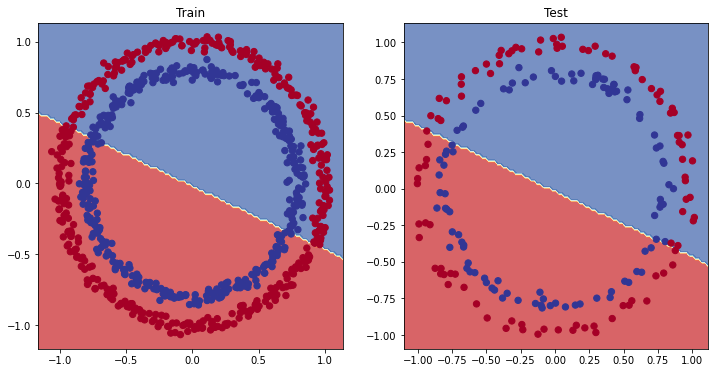

In [24]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [25]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
print(len(X_regression))

100


In [26]:
# Cretae train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

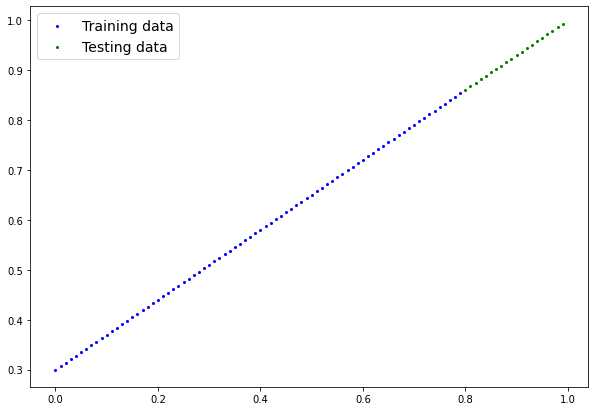

In [27]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjusting `model_1` to fit the straight line

In [28]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [30]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on right device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Creating a train loop
for epoch in range(epochs):
  ### Training
  model_2.train()
  y_preds = model_2(X_train_regression)
  loss = loss_fn(y_preds, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    test_preds = model_2(X_test_regression)
    test_loss = loss_fn(test_preds, y_test_regression)

  # Print out whats happening
  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 50 | Loss: 0.07625 | Test loss: 0.02102
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 150 | Loss: 0.07135 | Test loss: 0.02059
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 250 | Loss: 0.06361 | Test loss: 0.02465
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 350 | Loss: 0.06149 | Test loss: 0.01186
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 450 | Loss: 0.05039 | Test loss: 0.00524
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 550 | Loss: 0.06327 | Test loss: 0.02643
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 650 | Loss: 0.05504 | Test loss: 0.00691
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 750 | Loss: 0.06133 | Test loss: 0.01351
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 850 | Loss: 0.05542 | Test loss: 0.01048
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603
Epoch: 950 | Loss: 0.06437 | Test loss: 0.02551


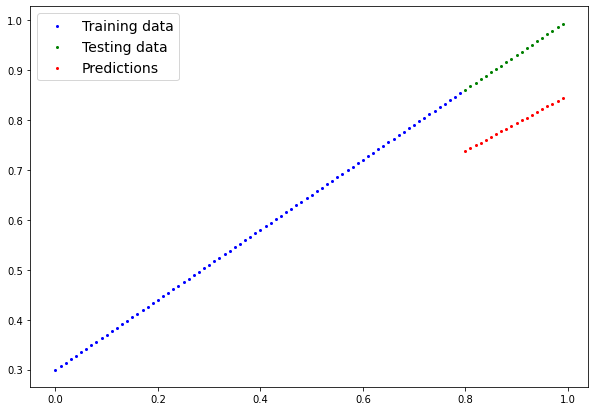

In [31]:
# Turn on evaluation mode
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight line and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

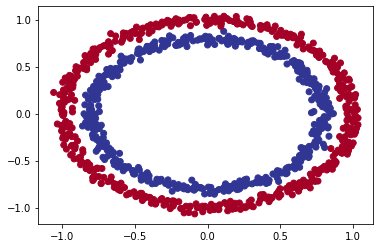

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [33]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### 6.2 Building a model with non-linearity

- Linear = straight lines
- Non-linear = non-straight lines

In [34]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.layer_1(x)
    z = self.relu(z)
    z = self.layer_2(z)
    z = self.relu(z)
    z = self.layer_3(z)

    return z

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [35]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.2 Training a model with non-linearity

In [36]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Take the step
  optimizer.step()

  ### Testing
  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test loss: 0.69319 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69115 | Acc: 52.88% | Test loss: 0.69102 | Test acc: 52.50%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37% | Test loss: 0.68940 | Test acc: 55.00%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00% | Test loss: 0.68723 | Test acc: 56.00%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75% | Test loss: 0.68411 | Test acc: 56.50%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75% | Test loss: 0.67941 | Test acc: 56.50%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50% | Test loss: 0.67285 | Test acc: 56.00%
Epoch: 700 | Loss: 0.66659 | Acc: 58.38% | Test loss: 0.66322 | Test acc: 59.00%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00% | Test loss: 0.64757 | Test acc: 67.50%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00% | Test loss: 0.62145 | Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [37]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

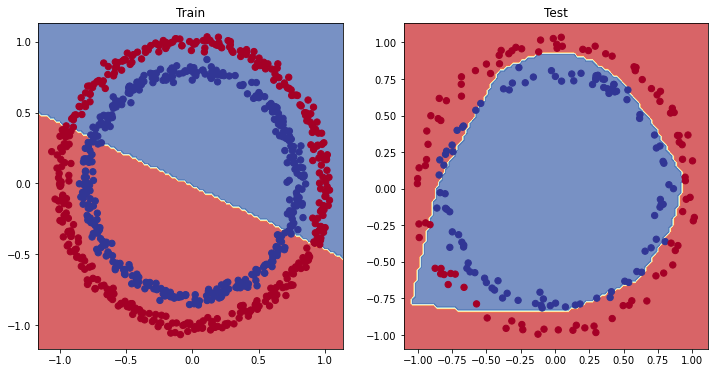

In [38]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test);

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

In [39]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype

torch.float32

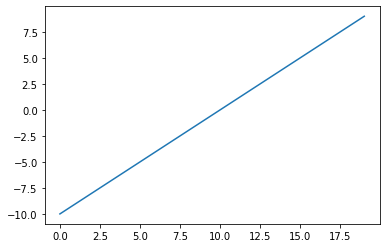

In [40]:
# Visualize the tensor
plt.plot(A);

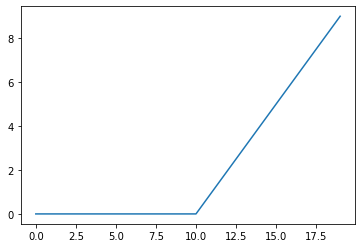

In [41]:
plt.plot(torch.relu(A));

In [42]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

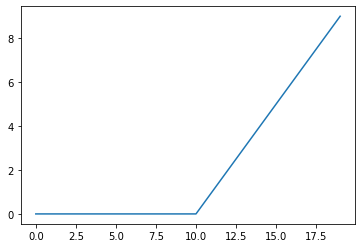

In [43]:
# Plot relu
plt.plot(relu(A));

## 8. Putting it all together with multi-class classification problem

- Binary classification = one thing or another
- Multi-class classification = more than one thing or another

### 8.1 Creating toy multi-class dataset

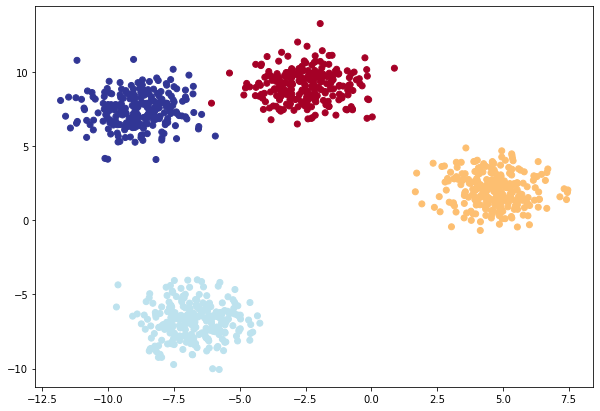

In [64]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Setup hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.1,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building multi-class classification model in PyTorch

In [65]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [66]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Inittializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features to the model
      hidden_units (int): Number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

# Create an instance of the model
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification

In [67]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilites for a multi-class classification

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities to prediction labels.

In [75]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:5]

tensor([[-0.7281, -0.6908, -1.4879, -1.0998],
        [-0.1029, -0.9560, -0.6084, -0.1398],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4663, -0.5439, -1.0189, -0.7548],
        [-0.2781, -1.3048, -1.1071, -0.3475]])

In [69]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [70]:
# Convert our model's logit outputs to prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:5])

tensor([[0.3130, 0.3248, 0.1464, 0.2158],
        [0.3341, 0.1424, 0.2015, 0.3220],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3077, 0.2847, 0.1771, 0.2306],
        [0.3666, 0.1313, 0.1600, 0.3421]])


In [71]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [76]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.15334, Acc: 38.75% | Test Loss: 1.06920, Test Acc: 45.50%
Epoch: 10 | Loss: 0.62575, Acc: 98.38% | Test Loss: 0.64251, Test Acc: 99.00%
Epoch: 20 | Loss: 0.39534, Acc: 99.75% | Test Loss: 0.39902, Test Acc: 100.00%
Epoch: 30 | Loss: 0.21203, Acc: 99.88% | Test Loss: 0.20419, Test Acc: 100.00%
Epoch: 40 | Loss: 0.07728, Acc: 99.88% | Test Loss: 0.07080, Test Acc: 100.00%
Epoch: 50 | Loss: 0.03859, Acc: 99.88% | Test Loss: 0.03492, Test Acc: 100.00%
Epoch: 60 | Loss: 0.02586, Acc: 99.88% | Test Loss: 0.02274, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01970, Acc: 99.88% | Test Loss: 0.01676, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01614, Acc: 99.88% | Test Loss: 0.01325, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01383, Acc: 99.88% | Test Loss: 0.01099, Test Acc: 100.00%


### 8.6 Making and evaluating predictions with PyTorch multi-class model

In [77]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.0434,  5.5118, -6.6285, -7.6321],
        [-2.3893, -6.2043, -3.5664,  3.1259],
        [-3.2966, -3.8037,  3.1527, -2.6344],
        [-1.1687,  4.0800, -3.9627, -5.0541],
        [ 3.4446, -1.8448, -7.9758, -6.1288],
        [-2.8625, -7.0409, -3.9781,  3.5923],
        [-3.0241, -3.4008,  2.8598, -2.2580],
        [ 3.1358, -3.7410, -6.4665, -3.6547],
        [-3.9970, -4.5866,  3.6432, -3.2070],
        [ 3.2315, -3.0277, -6.9001, -4.4956]])

In [78]:
# Go from logits -> Prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.4207e-03, 9.9857e-01, 5.3322e-06, 1.9546e-06],
        [4.0035e-03, 8.8232e-05, 1.2338e-03, 9.9467e-01],
        [1.5728e-03, 9.4719e-04, 9.9443e-01, 3.0497e-03],
        [5.2248e-03, 9.9435e-01, 3.1964e-04, 1.0731e-04],
        [9.9490e-01, 5.0192e-03, 1.0914e-05, 6.9203e-05],
        [1.5697e-03, 2.4052e-05, 5.1441e-04, 9.9789e-01],
        [2.7544e-03, 1.8898e-03, 9.8943e-01, 5.9258e-03],
        [9.9778e-01, 1.0292e-03, 6.7421e-05, 1.1219e-03],
        [4.7983e-04, 2.6610e-04, 9.9820e-01, 1.0573e-03],
        [9.9761e-01, 1.9081e-03, 3.9707e-05, 4.3963e-04]])

In [79]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

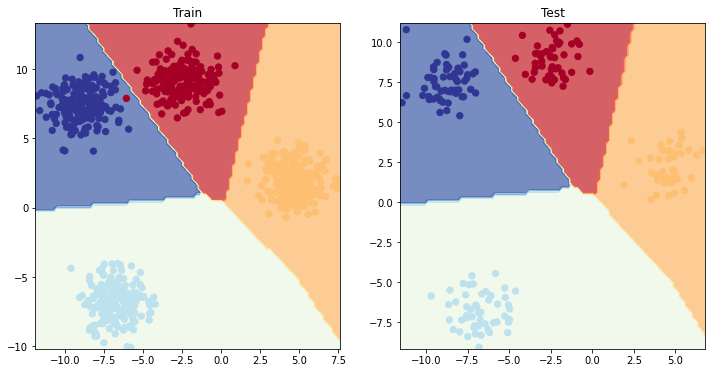

In [80]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test);

## 9. A few more classification metrics

- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix
- Classification report


In [81]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 32.8 MB/s eta 0:00:00


In [83]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(1.)